# Irradiated Monkeys Cont.
In this notebook I will elaborte on the work with the A_monkeys_preliminary findings

Specifically, I will focus on the following:

1.) Combining the biomarker and health-outcome data in more complex ways 

2.) Utilizing dimentionality reduction for vizualization and training

3.) Automate the cycling through of predictions

In [1]:
# handling data
import pandas as pd
import numpy as np
import datetime

# visualizing data
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

# Statistics
from scipy import stats
#import statsmodels.api as sm
import statsmodels.imputation.mice as smi
import scipy.cluster.hierarchy as hac
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.gridspec as gridspec
import math
import random


#SHAP Value stuff
import shap
from shap import TreeExplainer
from shap import GradientExplainer
from shap import DeepExplainer
from shap import KernelExplainer
from shap import SamplingExplainer
from shap import PartitionExplainer

#ML stuff
import catboost
from catboost import CatBoostClassifier, Pool, CatBoostRegressor, CatBoost

#language handling
#import bert


#from mxnet import nd, autograd, gluon
#from mxnet.gluon import nn, rnn
#import mxnet as mx


print("Setup Complete")

Setup Complete


In [2]:
pwd

'/Users/aidanlew/monkeys'

In [4]:
cd '/Users/aidanlew/Documents'

/Users/aidanlew/Documents


In [5]:
def parser(x):
    return datetime.datetime.strptime(x,'%d-%m-%y')


# Combining data
Fusing the biomarker and health data in the following ways for more robust predicitons/pattern recognition:

1.) Non-datetime biomarker data with the binary health outcome data

2.) Datetime biomarker and health outcome data

3.) Datetime biomarker and health coutcome data with the more subjective text

## 1.) Non-datetime biomarker data with the binary health outcome data


## Data setup

In [29]:
#Makee a df were all the data is present (except irrad data for the controls)
minbio_monkey_df = pd.read_excel('../Documents/full_monkey_data_r2.xlsx',
                    #sheet_name=1,
                    skiprows = 0,
                    usecols = ['ID', 'Species', 'IRRAD', 'SEX',
       'TYPE', 'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD',
       'DOSE_(Gy)', 'AGE', 'WBC_(K/uL)', 'RBC_(M/uL)', 'Hemaglobin_(HGB_g/dL)',
       'Hemocrit_(HCT_%)', 'Mean_corpuscular_volume_(MCV_fL)',
       'Mean_corpuscular_hemaglobin_(MCH_pg)',
       'Mean_corpuscular_hemaglobin_concentration_(MCHC_g/dL)', 'NEUT_(%)',
       'LYMPHOCYTES_(%)', 'MONO_(%)', 'EOS_(%)', 'BASO_(%)', 'ABS_NEUT_(/uL)',
       'ABS_LYMPH_(/uL)', 'ABS_MONO_(/uL)', 'ABS_EOS_(/uL)', 'ABS_BASO_(/uL)',
       'PLATLET_COUNT_(K/uL)'],
                    engine = 'openpyxl',
                    date_parser=parser
                         )

#Set the index to the monkey ID and make the labels not read as integers
#minbio_monkey_df.set_index(['ID'])
#minbio_monkey_df['ID'] = solid_monkey_df['ID'].astype(str)

#minbio_monkey_df.dropna(axis=0, inplace=True) 

minbio_monkey_df.columns
#minbio_monkey_df.tail()

Cannot parse header or footer so it will be ignored


Index(['ID', 'Species', 'IRRAD', 'SEX', 'TYPE', 'DAYS_SINCE_IRRAD',
       'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD', 'DOSE_(Gy)', 'AGE',
       'WBC_(K/uL)', 'RBC_(M/uL)', 'Hemaglobin_(HGB_g/dL)', 'Hemocrit_(HCT_%)',
       'Mean_corpuscular_volume_(MCV_fL)',
       'Mean_corpuscular_hemaglobin_(MCH_pg)',
       'Mean_corpuscular_hemaglobin_concentration_(MCHC_g/dL)', 'NEUT_(%)',
       'LYMPHOCYTES_(%)', 'MONO_(%)', 'EOS_(%)', 'BASO_(%)', 'ABS_NEUT_(/uL)',
       'ABS_LYMPH_(/uL)', 'ABS_MONO_(/uL)', 'ABS_EOS_(/uL)', 'ABS_BASO_(/uL)',
       'PLATLET_COUNT_(K/uL)'],
      dtype='object')

In [8]:
minhealth_monkey_df = pd.read_excel('../Documents/demographic_data_r2.xlsx',
                    sheet_name=1,
                    skiprows = 0,
                    #usecols = ,
                    engine = 'openpyxl',
                    date_parser=parser
                         )

In [30]:
#Makee a df were all the data is present (except irrad data for the controls)
minhealth_monkey_df = pd.read_excel('../Documents/demographic_data_r2.xlsx',
                    sheet_name=1,
                    skiprows = 0,
                    #usecols = ,
                    engine = 'openpyxl',
                    date_parser=parser
                         )

#Set the index to the monkey ID and make the labels not read as integers
#minhealth_monkey_df.set_index(['ID'])
#minhealth_monkey_df['ID'] = health_monkey_df['ID'].astype(str)

#health_monkey_df.columns
minhealth_monkey_df.head(10)

# Turn the Y/N to 1/0 and LIVING/DECESED to 1/0
#copy over the OG df
minmod_health_monkey_df = minhealth_monkey_df.copy()

# Y to 1
# For some reason, multiple columns together is seen as a df and .map() doesn't work
# Need to do the .map() before the .fillna()
minmod_health_monkey_df['Diabetes_(Y/N)'] = minmod_health_monkey_df['Diabetes_(Y/N)'].map({'Y': 1})
minmod_health_monkey_df['Cataracts_(Y/N)'] = minmod_health_monkey_df['Cataracts_(Y/N)'].map({'Y': 1})
minmod_health_monkey_df['Arthritis_(Y/N)'] = minmod_health_monkey_df['Arthritis_(Y/N)'].map({'Y': 1})
minmod_health_monkey_df['Periodontitis_(Y/N)'] = minmod_health_monkey_df['Periodontitis_(Y/N)'].map({'Y': 1})
minmod_health_monkey_df['GI_(Y/N)'] = minmod_health_monkey_df['GI_(Y/N)'].map({'Y': 1})
minmod_health_monkey_df['Behavior_(Y/N)'] = minmod_health_monkey_df['Behavior_(Y/N)'].map({'Y': 1})
minmod_health_monkey_df['Tumor_(Y/N)'] = minmod_health_monkey_df['Tumor_(Y/N)'].map({'Y': 1})
minmod_health_monkey_df['Heart_(Y/N)'] = minmod_health_monkey_df['Heart_(Y/N)'].map({'Y': 1})
minmod_health_monkey_df['Hypertension_(Y/N)'] = minmod_health_monkey_df['Hypertension_(Y/N)'].map({'Y': 1})
minmod_health_monkey_df['Testicular Atrophy_(Y/N)'] = minmod_health_monkey_df['Testicular Atrophy_(Y/N)'].map({'Y': 1})
minmod_health_monkey_df['Ovarian Dysfunction_(Y/N)'] = minmod_health_monkey_df['Ovarian Dysfunction_(Y/N)'].map({'Y': 1})
minmod_health_monkey_df['Hepatic_(Y/N)'] = minmod_health_monkey_df['Hepatic_(Y/N)'].map({'Y': 1})
minmod_health_monkey_df['Kidney_(Y/N)'] = minmod_health_monkey_df['Kidney_(Y/N)'].map({'Y': 1})
minmod_health_monkey_df['Lung_(Y/N)'] = minmod_health_monkey_df['Lung_(Y/N)'].map({'Y': 1})
minmod_health_monkey_df['Bone_(Y/N)'] = minmod_health_monkey_df['Bone_(Y/N)'].map({'Y': 1})
minmod_health_monkey_df['Overweight_(Y/N)'] = minmod_health_monkey_df['Overweight_(Y/N)'].map({'Y': 1})
minmod_health_monkey_df['Underweight_(Y/N)'] = minmod_health_monkey_df['Underweight_(Y/N)'].map({'Y': 1})
minmod_health_monkey_df['Brain Lesion_(Y/N)'] = minmod_health_monkey_df['Brain Lesion_(Y/N)'].map({'Y': 1})


# NaN to 0
minmod_health_monkey_df[['Diabetes_(Y/N)', 'Cataracts_(Y/N)', 'Arthritis_(Y/N)',
       'Periodontitis_(Y/N)', 'GI_(Y/N)', 'Behavior_(Y/N)', 'Tumor_(Y/N)',
       'Heart_(Y/N)', 'Hypertension_(Y/N)', 'Testicular Atrophy_(Y/N)',
       'Ovarian Dysfunction_(Y/N)', 'Hepatic_(Y/N)', 'Kidney_(Y/N)',
       'Lung_(Y/N)', 'Bone_(Y/N)', 'Overweight_(Y/N)', 'Underweight_(Y/N)',
       'Brain Lesion_(Y/N)']]= minmod_health_monkey_df[['Diabetes_(Y/N)', 'Cataracts_(Y/N)', 'Arthritis_(Y/N)',
       'Periodontitis_(Y/N)', 'GI_(Y/N)', 'Behavior_(Y/N)', 'Tumor_(Y/N)',
       'Heart_(Y/N)', 'Hypertension_(Y/N)', 'Testicular Atrophy_(Y/N)',
       'Ovarian Dysfunction_(Y/N)', 'Hepatic_(Y/N)', 'Kidney_(Y/N)',
       'Lung_(Y/N)', 'Bone_(Y/N)', 'Overweight_(Y/N)', 'Underweight_(Y/N)',
       'Brain Lesion_(Y/N)']].fillna(0, #inplace=True
)

#LIVING/DECESED to 1/0
minmod_health_monkey_df['Animal_Status'] = minmod_health_monkey_df['Animal_Status'].map({'LIVING':1, 'DECEASED': 0})


#minmod_health_monkey_df.head(10)
minmod_health_monkey_df.columns

Index(['ID', 'Time_Under_Observation_(yrs)', 'Dose_(Gy)', 'Irrad_Age_(months)',
       'Years_Since_Irrad', 'Current_Age_(years)', 'Animal_Status',
       'Diabetes_(Y/N)', 'Cataracts_(Y/N)', 'Arthritis_(Y/N)',
       'Periodontitis_(Y/N)', 'GI_(Y/N)', 'Behavior_(Y/N)', 'Tumor_(Y/N)',
       'Heart_(Y/N)', 'Hypertension_(Y/N)', 'Testicular Atrophy_(Y/N)',
       'Ovarian Dysfunction_(Y/N)', 'Hepatic_(Y/N)', 'Kidney_(Y/N)',
       'Lung_(Y/N)', 'Bone_(Y/N)', 'Overweight_(Y/N)', 'Underweight_(Y/N)',
       'Brain Lesion_(Y/N)'],
      dtype='object')

## Concatonating data
Pandas has a .join(), .merge(), and .concat() methods

Need to either delete or ovelap the ID, Dose_(Gy), Irrad_Age_(months), Years_Since_Irrad, AGE, and the equivilents.

Issue: not all monkeys are accounted for in the health data, and there are far more samples in the bio data - make sure it fills down??? based on date???


In [15]:
minbio_monkey_df.join(minmod_health_monkey_df, on='ID',rsuffix='_right')

,ID,Species,IRRAD,SEX,TYPE,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,MONTHS AT IRRAD,DOSE_(Gy),AGE,...,Hypertension_(Y/N),Testicular Atrophy_(Y/N),Ovarian Dysfunction_(Y/N),Hepatic_(Y/N),Kidney_(Y/N),Lung_(Y/N),Bone_(Y/N),Overweight_(Y/N),Underweight_(Y/N),Brain Lesion_(Y/N)
0,2061,Rhesus-Chinese,No,F,Clinical,NaN,NaN,NaN,NaN,10.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2061,Rhesus-Chinese,No,F,Research,NaN,NaN,NaN,NaN,10.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2061,Rhesus-Chinese,No,F,Research,NaN,NaN,NaN,NaN,10.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2061,Rhesus-Chinese,No,F,Research,NaN,NaN,NaN,NaN,11.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2061,Rhesus-Chinese,No,F,Research,NaN,NaN,NaN,NaN,11.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4547,2112,Rhesus-Chinese,No,M,Research,NaN,NaN,NaN,NaN,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4548,2112,Rhesus-Chinese,No,M,Research,NaN,NaN,NaN,NaN,21.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4549,2210,Rhesus-Indian,No,F,Research,NaN,NaN,NaN,NaN,25.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4550,2210,Rhesus-Indian,No,F,Research,NaN,NaN,NaN,NaN,25.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2.) Datetime biomarker and health outcome data


## 3.) Datetime biomarker and health coutcome data with the more subjective text

# Dimentionality reduction
Can I initially reduce the number of features for faster training and better vizualization with the same amount of power?

Using Non-negative matrix factorization (NMF) because it seemed well used and effective
 - however, has to be linearly seperatable

Also using t-Distributed Stochastic Neighbor Embedding (t-SNE) because it works well for non-linear data

Articel on different techniques:
https://neptune.ai/blog/dimensionality-reduction#:~:text=Advantages%20and%20disadvantages-,What%20is%20dimensionality%20reduction%3F,variables%20are%20also%20called%20features.

Sklearn NMF https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html

Sklearn TSNE https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html


In [165]:
#get the single monkey data in a form that can be understood by the NMF and TSNE - no text or datetime

single_red_df = single_monkey_df.copy()
single_red_df = single_red_df.drop(['Species','SEX', 'TYPE','IRRAD_DATE','DOB','SAMPLE_DATE',], axis =1)
#single_red_df.head(2)

#Turn 'Yes' and 'No' to 1 & 0 - numerical
single_red_df['IRRAD'] = single_red_df['IRRAD'].map({'Yes': 1, 'No': 0})


single_red_df.head(2)

,ID,IRRAD,DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,MONTHS AT IRRAD,DOSE_(Gy),AGE,WBC_(K/uL),RBC_(M/uL),Hemaglobin_(HGB_g/dL),...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
33,2046,1,1303.0,43.0,81.0,1.14,10.3,3.8,6.08,14.2,...,44.6,5.5,0.5,0.0,1877,1695,209,19,0,276
34,2046,1,1344.0,44.0,81.0,1.14,10.4,7.0,5.38,12.2,...,40.5,7.4,0.0,0.0,3647,2835,518,0,0,386


In [167]:
from sklearn.manifold import TSNE

#17 is the max for perplexityin this instance
monkey_tsne = TSNE(n_components=2, 
                   perplexity=17
                   ).fit_transform(single_red_df)


The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


In [171]:
df_subset1 = monkey_tsne[:,0]
df_subset2 = monkey_tsne[:,1]

array([ -58.8492,  -66.9556,   37.9748,   -7.0038,   56.2467,   93.4242,
         79.3676,   31.9424, -101.5552,  108.6782, -100.4777,  -46.1296,
        -50.1352,    1.0581,   13.0641,  -11.5553,  -15.6544,   48.4498],
      dtype=float32)

<AxesSubplot: >

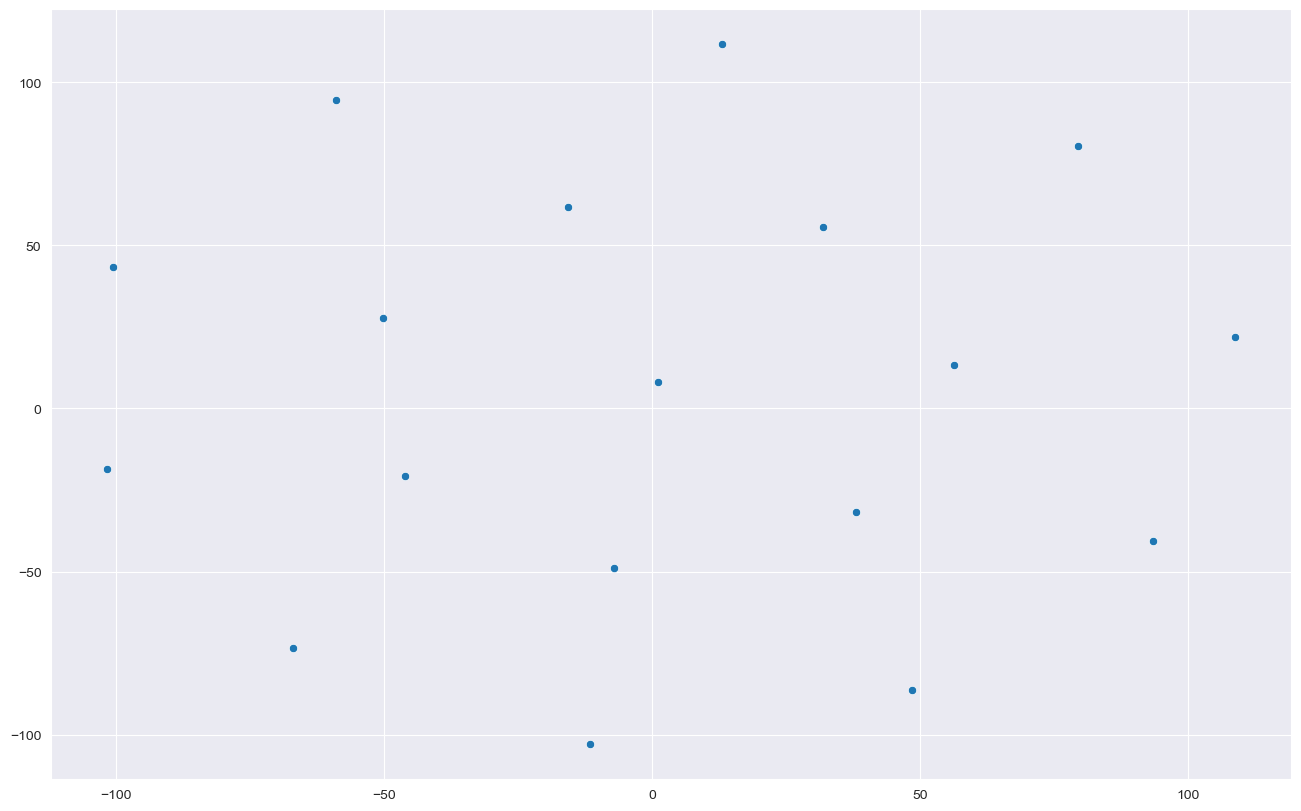

In [186]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=df_subset1, y=df_subset2,
    #hue="y",
    palette=sns.color_palette("hls", 10),
    #data=df_subset,
    legend="full",
    alpha=1
)

## UMAP
Want to try UMAP with the health outcome and combined data

In [32]:
# Same setup as from the docs example: https://umap-learn.readthedocs.io/en/latest/basic_usage.html
import umap.plot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
%matplotlib inline
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

import umap
reducer = umap.UMAP()



print('Setup Complete')

Setup Complete


In [33]:
#need to scale the vales to z-scores to get them all on the same page

#Make df with the blood analytics with no missing values - NaN as 0, see if there's a better way
minmod_health_monkey_df.copy()
healthumap_df = minmod_health_monkey_df.fillna(0)

#healthumap_df.head()

#Scale the blood to z-scores
healthumap_df = healthumap_df.values
scaled_healthumap_df = StandardScaler().fit_transform(healthumap_df)

In [34]:
# Want it to be (n, 2) for UMAP to work
embedding = reducer.fit_transform(scaled_healthumap_df)
embedding.shape

(152, 2)

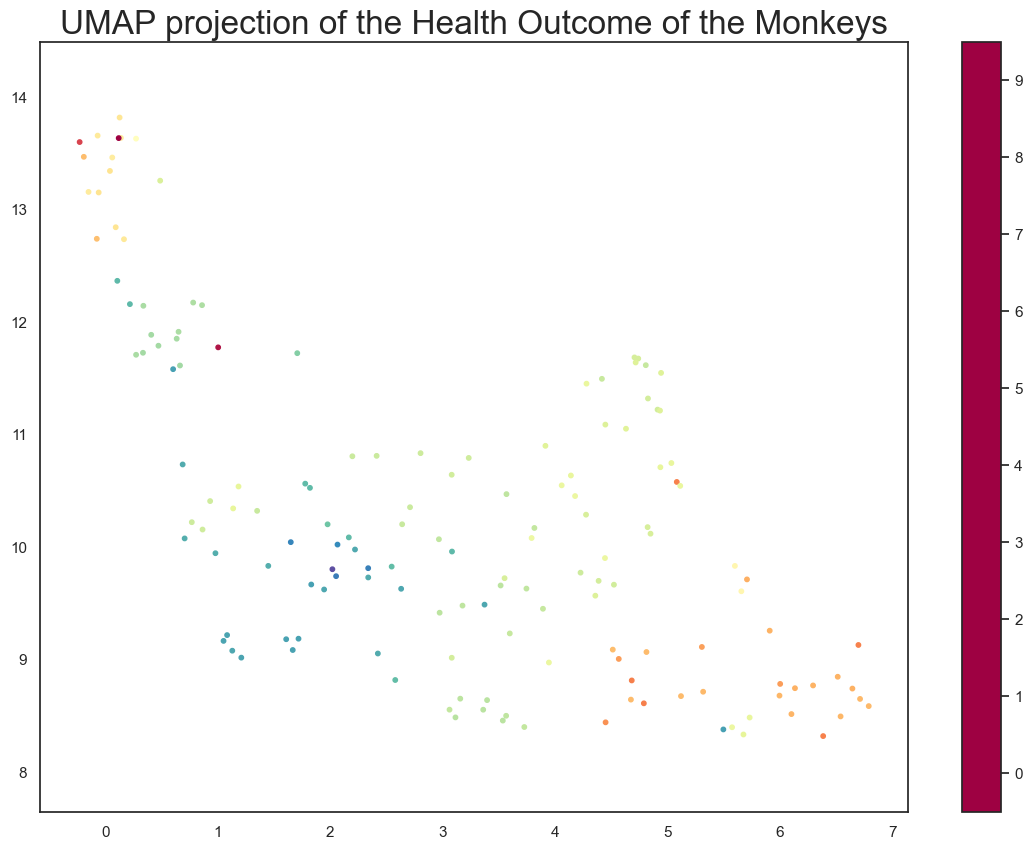

In [39]:
# Simply visualize the UMAP
plt.scatter(embedding[:, 0], 
            embedding[:, 1], 
            c=minmod_health_monkey_df.ID, 
            cmap='Spectral', 
            s=10
           )

#show the spiderweb
#umap.plot.connectivity(mapper, edge_bundling='hammer')

plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the Health Outcome of the Monkeys', fontsize=24);

## Interactive Health outcome UMAP

In [41]:
# Set up interactive loading of 
from io import BytesIO
from PIL import Image
import base64
import bokeh

def embeddable_image(data):
    img_data = 255 - 15 * data.astype(np.uint8)
    image = Image.fromarray(img_data, mode='L').resize((64, 64), Image.Resampling.BICUBIC)
    buffer = BytesIO()
    image.save(buffer, format='png')
    for_encoding = buffer.getvalue()
    return 'data:image/png;base64,' + base64.b64encode(for_encoding).decode()

#This part has to go below up above
import bokeh
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.palettes import Spectral10

output_notebook()

Loading BokehJS ...

In [52]:
umap1_df = pd.DataFrame(embedding, columns=('x', 'y'))

datasource = ColumnDataSource(umap1_df)
#color_mapping = CategoricalColorMapper(factors=minmod_health_monkey_df['ID'],
#                                       palette='Turbo256')




plot_figure = figure(
    title='UMAP projection of the Health outcome dataset',
    plot_width=600,
    plot_height=600,
    tools=('pan, wheel_zoom, reset')
)

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@image' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 16px; color: #224499'>Digit:</span>
        <span style='font-size: 18px'>@digit</span>
    </div>
</div>
"""))

plot_figure.circle(
    'x',
    'y',
    source=umap1_df,
    #color=dict(field='digit', #transform=color_mapping),
    line_alpha=0.6,
    fill_alpha=0.6,
    size=4
)

show(plot_figure)

### It works, but the number of points is so large it gives them all grey colors, might work with just monkeys ###

# Automate cycling through feature predicitons
Instead of seting up a single label-train dynamic, can I predict every single feature based on the same data?

# Conclusions